In [84]:
import pandas as pd


def read_csv(filename="water_consumption.csv"):
    return pd.read_csv(filename)



In [85]:
import matplotlib as plt


# Graphically represent data through bar graphs
def plot_histogram(data, title, start_month, end_month, label="watter Consumption (m3)"):
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(data.index, data.values, color="blue")
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel(label)
    plt.xticks(range(start_month, end_month + 1))
    plt.show()

In [86]:
import matplotlib as plt

def plot_park_histogram(data, title, park_name):
    plt.hist(data, bins=10, align="mid")
    plt.ylabel("Frequency")
    plt.xlabel("Consumption")
    plt.title(f"{title} for Park {park_name} (10 bins)")
    plt.show()

    plt.hist(data, bins=100)
    plt.ylabel("Frequency")
    plt.xlabel("Consumption")
    plt.title(f"{title} for Park {park_name} (100 bins)")
    plt.show()

Available parks:
['park' 'as']
Available years:
[2000]


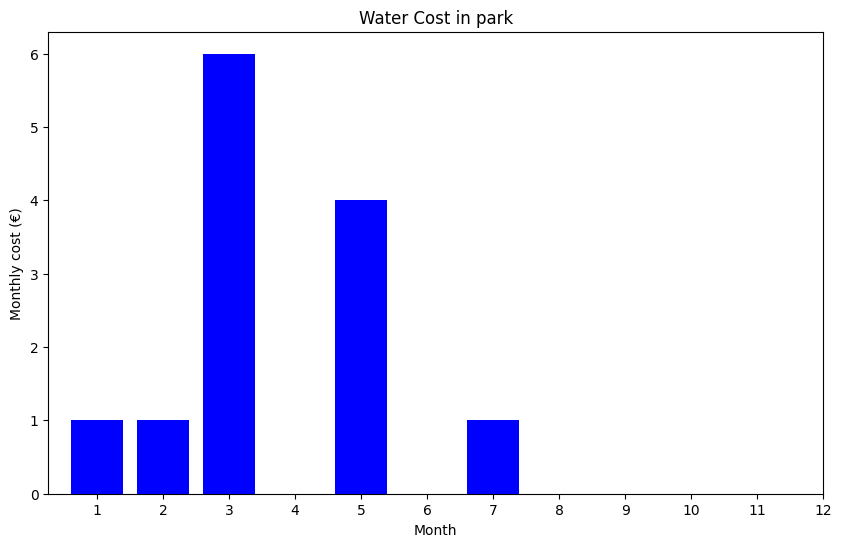

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew

# Load the data
df = pd.read_csv("water_consumption.csv")


def barplot_monthly_water_consumption():
    # User inputs
    print("Available parks:")
    print(df["Park Identification"].unique())

    park_id = input("Enter the park identification: ")
    # Filter the data based on the park identification
    park_data = df[df["Park Identification"] == park_id]

    # Get the unique years in the park data
    years = park_data["Year"].unique()

    print("Available years:")
    print(years)

    year = int(input("Enter the year: "))
    start_month = int(input("Enter the start month (1-12): "))
    end_month = int(input("Enter the end month (1-12): "))

    # Filter the data based on user inputs
    filtered_data = df[
        (df["Park Identification"] == park_id)
        & (df["Year"] == year)
        & (df["Month"] >= start_month)
        & (df["Month"] <= end_month)
    ]

    # Calculate the total water consumption for each month
    choosen_park_data = filtered_data.groupby("Month")["Consumption"].sum()

    plot_histogram(
        choosen_park_data,
        f"Water Cost in {park_id}",
        start_month,
        end_month,
        label="Monthly cost (€)",
    )


barplot_monthly_water_consumption()

In [88]:
import numpy as np
from matplotlib import pyplot as plt


def average_park_consuption():

    parks = df["Park Identification"].unique()
    choosen_parks = []

    num_of_parks = int(
        input(
            "Choose the number of parks you want to calculate the average water consumption: "
        )
    )

    for _ in range(num_of_parks):
        inv_park = True
        while inv_park:
            print("Available parks: ")
            print(parks)
            park_id = input("Enter the park identification: ")
            if park_id in parks:
                choosen_parks.append(park_id)
                inv_park = False
                parks = np.delete(parks, np.where(parks == park_id))
            else:
                print("Invalid park identification. Try again.")

    # Filter the data based on user inputs
    filtered_data = df[(df["Park Identification"].isin(choosen_parks))]

    # calculate the average consumption per park
    average_consumption = filtered_data.groupby("Park Identification")[
        "Consumption"
    ].mean()

    print(average_consumption)

    plot_histogram(
        average_consumption, "Average water consumption", 0, num_of_parks - 1
    )

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew


def analyze_parks(df):
    # Filter out null values in the Consumption column
    filtered_df = df[df["Consumption"].notnull()]

    # Identify the park with the highest and lowest consumption
    highest_park = (
        filtered_df.groupby("Park Identification")["Consumption"].mean().idxmax()
    )
    lowest_park = (
        filtered_df.groupby("Park Identification")["Consumption"].mean().idxmin()
    )

    park_data = {}
    park_stats = {}

    # Calculate statistics for each park
    for park in [highest_park, lowest_park]:
        park_data[park] = filtered_df[filtered_df["Park Identification"] == park][
            "Consumption"
        ]
        mean = park_data[park].mean()
        median = park_data[park].median()
        std = park_data[park].std()
        skewness = skew(park_data[park])

        park_stats[park] = {
            "Mean": mean,
            "Median": median,
            "Std": std,
            "Skewness": skewness,
        }

        print(f"Park {park} Statistics:")
        print(f"Mean: {mean}, Median: {median}, Std: {std}, Skewness: {skewness}")

        # Build frequency tables
        freq_table = pd.cut(park_data[park], 5).value_counts().sort_index()
        rel_freq_table = freq_table / len(park_data[park])

        print("Frequency Table:")
        print(freq_table)
        print("Relative Frequency Table:")
        print(rel_freq_table)
        # Plot frequency tables
        freq_table.plot(kind="bar", title=f"Frequency Table for Park {park}")
        plt.show()

        rel_freq_table.plot(
            kind="bar", title=f"Relative Frequency Table for Park {park}"
        )
        plt.show()
        # Check for outliers
        Q1 = park_data[park].quantile(0.25)
        Q3 = park_data[park].quantile(0.75)
        IQR = Q3 - Q1
        outliers = park_data[park][
            (park_data[park] < (Q1 - 1.5 * IQR)) | (park_data[park] > (Q3 + 1.5 * IQR))
        ]

        print("Outliers:")
        print(outliers)

        # Plot histograms
        plt.hist(park_data[park], bins=10, align="mid")
        plt.ylabel("Frequency")
        plt.xlabel("Consumption")
        plt.title(f"Park {park} Consumption Histogram (10 bins)")
        plt.show()

        plt.hist(park_data[park], bins=100)
        plt.ylabel("Frequency")
        plt.xlabel("Consumption")
        plt.title(f"Park {park} Consumption Histogram (100 bins)")
        plt.show()

    print("SUMMARY: ")

    # Plot summary histogram
    plt.hist(
        park_data[highest_park],
        bins=10,
        alpha=0.5,
        label=f"Park {highest_park}",
        align="mid",
    )
    plt.hist(
        park_data[lowest_park],
        bins=10,
        alpha=0.5,
        label=f"Park {lowest_park}",
        align="mid",
    )
    plt.ylabel("Frequency")
    plt.xlabel("Consumption")
    plt.title("Park Consumption Histogram (10 bins)")
    plt.legend(loc="upper right")
    plt.show()

    plt.hist(
        park_data[highest_park],
        bins=10,
        alpha=0.5,
        label=f"Park {highest_park}",
        align="mid",
    )
    plt.hist(
        park_data[lowest_park],
        bins=10,
        alpha=0.5,
        label=f"Park {lowest_park}",
        align="mid",
    )
    plt.ylabel("Frequency")
    plt.xlabel("Consumption")
    plt.title("Park Consumption Histogram (100 bins)")
    plt.legend(loc="upper right")
    plt.show()

    for stat in ["Std", "Median", "Skewness"]:
        values = [park_stats[park][stat] for park in [highest_park, lowest_park]]
        plt.bar([highest_park, lowest_park], values)
        plt.title(f"{stat} by Park")
        plt.show()

